In [1]:
import os
import pathlib as Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# 1. Чтение данных и знакомство с данными

In [2]:
columns_to_drop = [
    'labor_minutes_per_unit',
    'material_cost_rub',
    'labor_cost_rub',
    'unit_price_rub',
    'target_labor_min'
]
target = 'target_unit_price_rub'

In [3]:
data = pd.read_csv(os.path.join('./data', 'mvp_quotes.csv'))
data = data.drop(columns=columns_to_drop)
# drop full duplicates
data = data.drop_duplicates()
print(f'Dataset length {len(data)}')
data.head()

Dataset length 21288


,rfq_id,customer_tier,material,thickness_mm,length_mm,width_mm,holes_count,bends_count,weld_length_mm,cut_length_mm,route,tolerance,surface_finish,coating,qty,due_days,engineer_score,part_weight_kg,target_unit_price_rub
0,10428,C,stainless,4.00,51.0,1398.0,6.0,0.0,75.0,NaN,NaN,precise,none,none,50.0,7.0,1.48,0.002,32.14
1,3686,B,steel,8.13,531.0,153.0,4.0,1.0,124.0,6742.0,laser_cut,precise,none,powder,2.0,21.0,-1.04,0.005,141.16
2,18045,C,steel,3.10,595.0,558.0,3.0,1.0,102.0,2450.0,laser_cut,standard,none,zinc,10.0,7.0,1.89,0.008,72.94
3,2361,A,steel,5.14,307.0,621.0,4.0,1.0,95.0,6207.0,NaN,standard,NaN,none,100.0,14.0,-0.02,NaN,67.20
4,16105,B,steel,1.07,1059.0,1108.0,5.0,NaN,276.0,557.0,waterjet_cut,standard,none,none,5.0,30.0,-1.64,0.010,62.38


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21288 entries, 0 to 21399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rfq_id                 21288 non-null  int64  
 1   customer_tier          21288 non-null  object 
 2   material               20460 non-null  object 
 3   thickness_mm           20234 non-null  float64
 4   length_mm              19722 non-null  float64
 5   width_mm               19393 non-null  float64
 6   holes_count            19593 non-null  float64
 7   bends_count            20378 non-null  float64
 8   weld_length_mm         20286 non-null  float64
 9   cut_length_mm          19657 non-null  float64
 10  route                  19397 non-null  object 
 11  tolerance              19808 non-null  object 
 12  surface_finish         19990 non-null  object 
 13  coating                20400 non-null  object 
 14  qty                    20495 non-null  float64
 15  due_day

In [5]:
# разделим признаки на числовые и категориальные
cat_features = ['customer_tier', 'material', 'route', 'tolerance', 'surface_finish', 'coating']
num_features = list(
    set(data.columns.drop(['rfq_id', target]))
    - set(cat_features)
)
num_features

['length_mm',
 'weld_length_mm',
 'due_days',
 'holes_count',
 'qty',
 'engineer_score',
 'thickness_mm',
 'part_weight_kg',
 'bends_count',
 'cut_length_mm',
 'width_mm']

In [6]:
data[num_features].describe()

,length_mm,weld_length_mm,due_days,holes_count,qty,engineer_score,thickness_mm,part_weight_kg,bends_count,cut_length_mm,width_mm
count,19722.000000,20286.000000,20185.000000,19593.00000,20495.000000,19580.000000,20234.000000,20393.000000,20378.000000,19657.000000,19393.000000
mean,1020.149376,98.945578,12.008075,3.00735,16.069188,-0.008548,5.345162,0.029797,2.000638,5007.669990,766.855154
std,564.879504,70.200432,6.592792,1.72885,24.149814,1.004218,3.081035,0.035616,1.408145,2850.500589,425.862001
min,50.000000,0.000000,3.000000,0.00000,1.000000,-4.070000,1.000000,0.000000,0.000000,100.000000,20.000000
25%,526.250000,47.000000,7.000000,2.00000,2.000000,-0.690000,3.070000,0.006000,1.000000,2534.000000,401.000000
50%,1018.000000,83.000000,10.000000,3.00000,5.000000,-0.010000,5.030000,0.017000,2.000000,4990.000000,768.000000
75%,1512.000000,134.000000,14.000000,4.00000,20.000000,0.660000,8.030000,0.040000,3.000000,7467.000000,1135.000000
max,1999.000000,581.000000,30.000000,12.00000,100.000000,4.480000,12.200000,0.277000,9.000000,9999.000000,1499.000000


# 2. Очистка данных

## 2.1  Удаляем записи без таргета

In [7]:
data[data[target]==0 | data[target].isna()].shape

(0, 19)

# 2.2 Избавляемся от дублей по id

In [8]:
# test than id is unique
unique_count = data['rfq_id'].nunique()
total_count = len(data)
if total_count==unique_count:
    print('All ids are unique')
else:
    duplicates_by_id = data[data.duplicated(subset=['rfq_id'], keep=False)]
    print(f'Numder of id duplicates - {len(duplicates_by_id)}')
    duplicates_by_id = duplicates_by_id.sort_values(by='rfq_id')
    print(duplicates_by_id.head(10))

Numder of id duplicates - 2576
       rfq_id customer_tier   material  thickness_mm  length_mm  width_mm  \
12912       9             B  stainless          5.04      117.0     383.0   
4305        9             B  stainless          5.04      117.0       NaN   
13389      30             A      steel           NaN        NaN     462.0   
3918       30             A        NaN          4.08        NaN     462.0   
1708       39             B   aluminum          4.20      381.0     384.0   
19865      39             B   aluminum           NaN      381.0     384.0   
14844      61             B      steel          3.17     1247.0     416.0   
3845       61             B      steel          3.17     1247.0     416.0   
7444       65             A   aluminum           NaN     1209.0     509.0   
9424       65             A   aluminum          8.16     1209.0     509.0   

       holes_count  bends_count  weld_length_mm  cut_length_mm       route  \
12912          4.0          NaN            

In [9]:
data = data.groupby('rfq_id').agg(
    lambda x: x.dropna().iloc[0] if not x.dropna().empty else None
).reset_index()
print(f'length data after drop duplicates by rfq_id - {len(data)}')

length data after drop duplicates by rfq_id - 20000


## 2.3 Заполняем пропуски модой для категориальных признаков и медианой для числовых

In [10]:
for col in cat_features:
    data[col] = data[col].fillna(data[col].mode()[0])

for col in num_features:
    data[col] = data[col].fillna(data[col].median())

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rfq_id                 20000 non-null  int64  
 1   customer_tier          20000 non-null  object 
 2   material               20000 non-null  object 
 3   thickness_mm           20000 non-null  float64
 4   length_mm              20000 non-null  float64
 5   width_mm               20000 non-null  float64
 6   holes_count            20000 non-null  float64
 7   bends_count            20000 non-null  float64
 8   weld_length_mm         20000 non-null  float64
 9   cut_length_mm          20000 non-null  float64
 10  route                  20000 non-null  object 
 11  tolerance              20000 non-null  object 
 12  surface_finish         20000 non-null  object 
 13  coating                20000 non-null  object 
 14  qty                    20000 non-null  float64
 15  du

Пропуски заполнили, дубликаты почистили

# 3 Анализ данных

## 3.1 Гистограммы для категориальных признаков

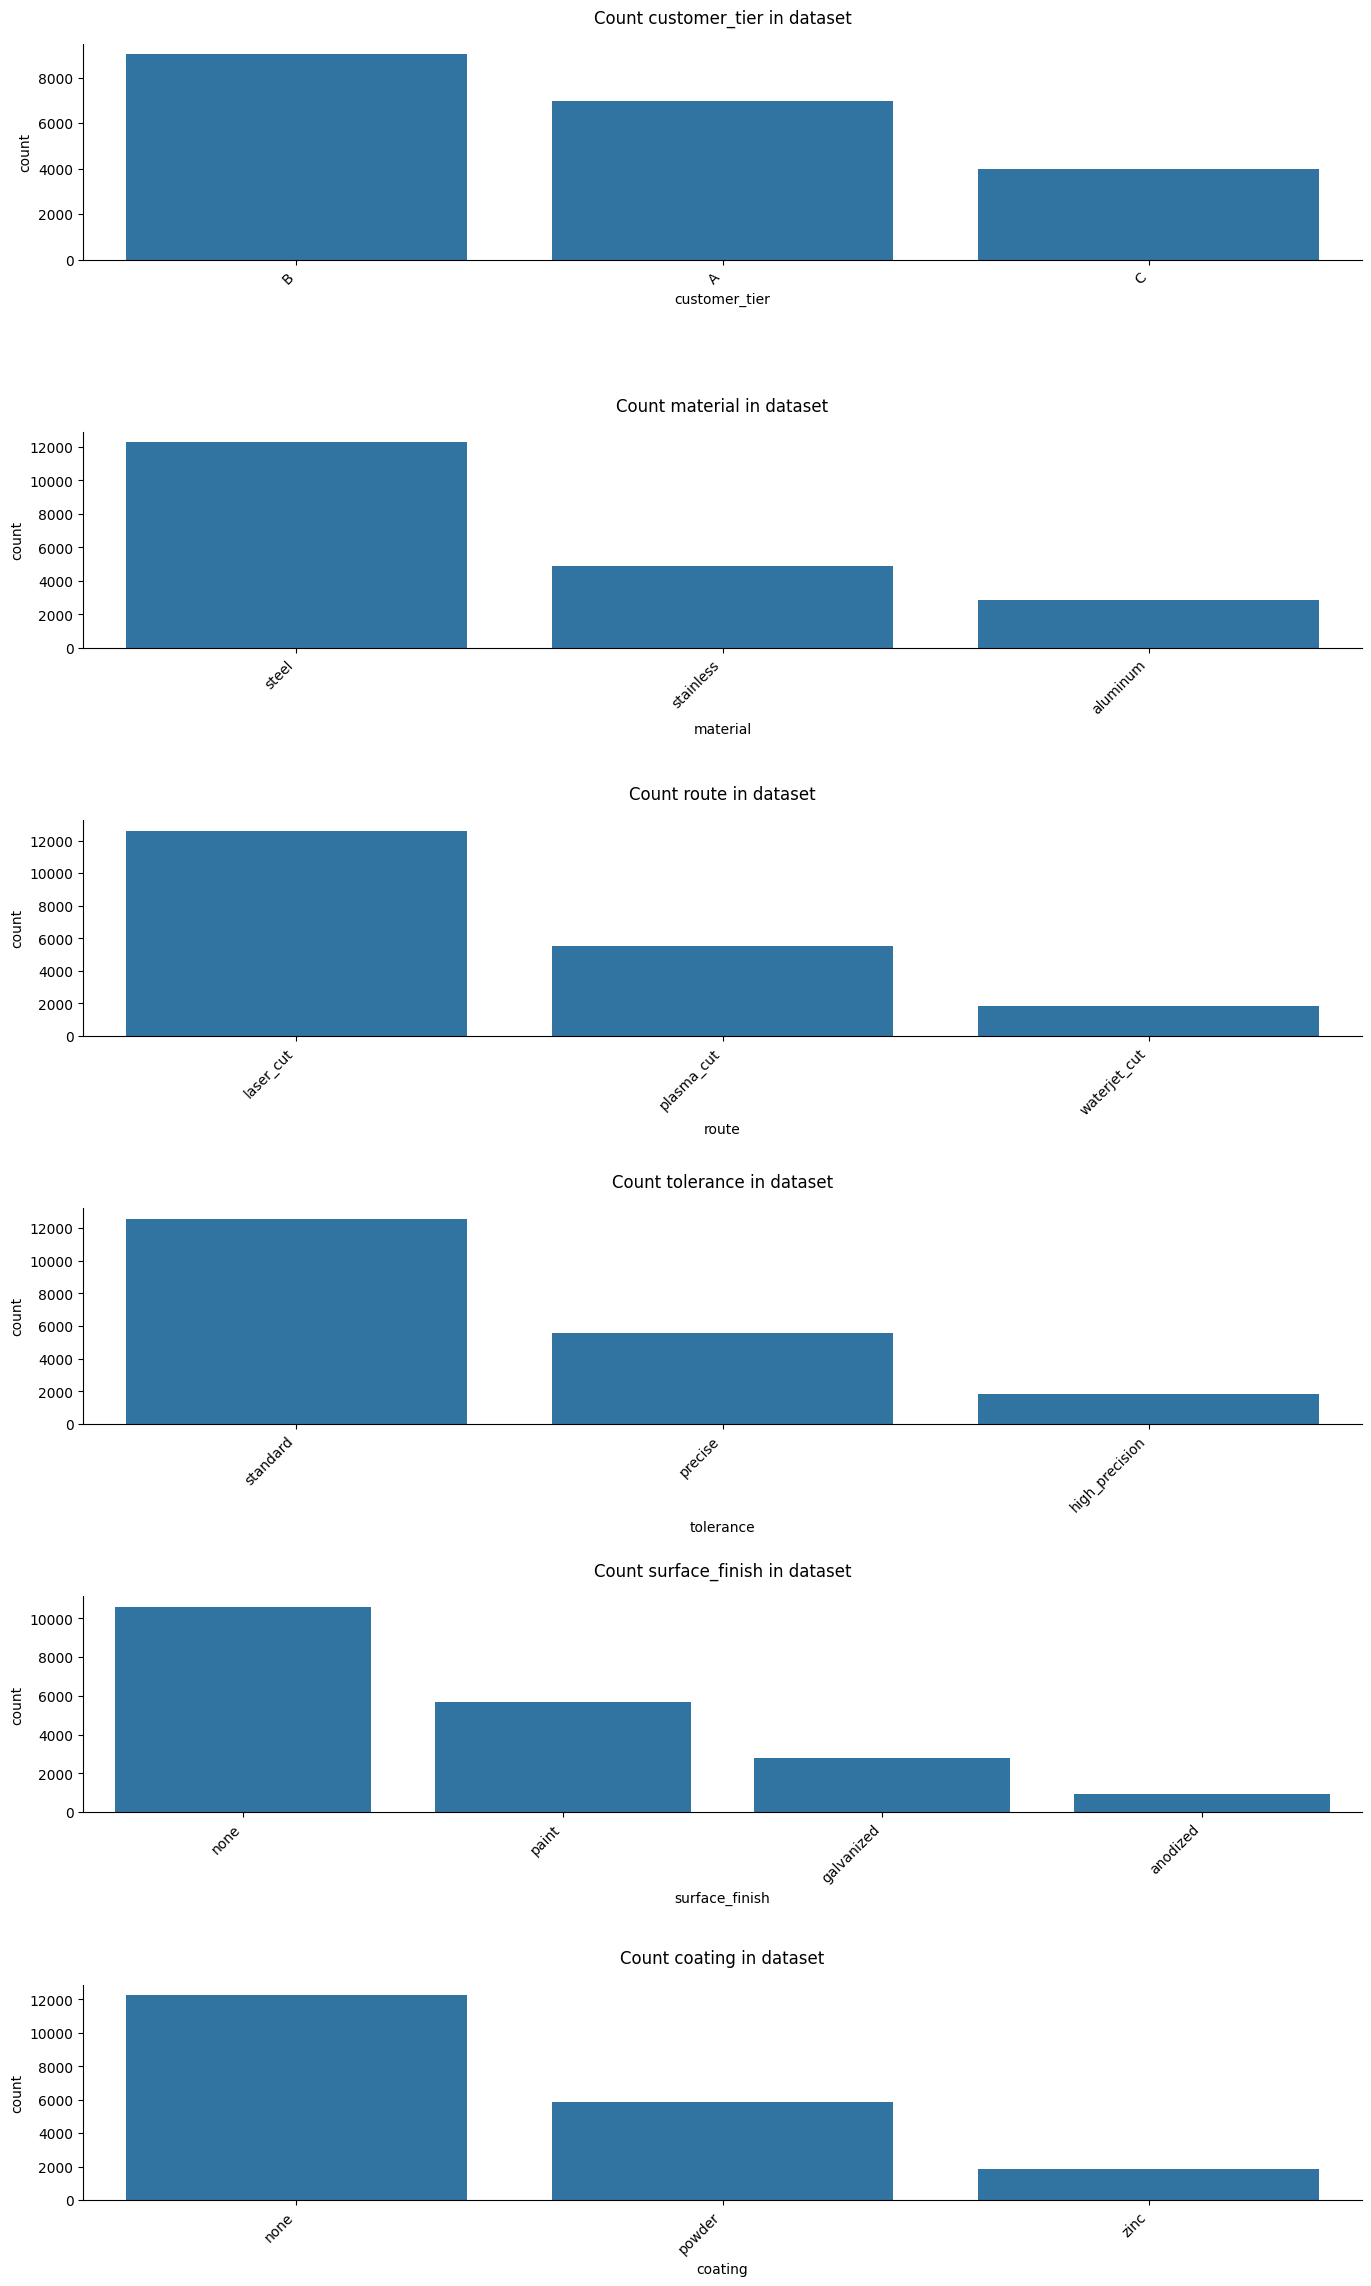

In [12]:
def plot_cat_hist(df, col, axs, index):
    df["id"] = list(df.index)
    y = "id"
    stat = ["count"]
    agg_df = df.groupby(col).agg({y: stat[0]}).reset_index(drop=False)
    agg_df.columns = [col, stat[0]]
    
    # Сортируем по убыванию для лучшей читаемости
    agg_df = agg_df.sort_values(stat[0], ascending=False)
    
    sns.barplot(data=agg_df, x=col, y=stat[0], ax=axs[index], order=agg_df[col])
    axs[index].set_xticklabels(agg_df[col].unique(), rotation=45, ha='right')  # Улучшенный поворот меток
    axs[index].set_title(f"Count {col} in dataset", fontsize=12, pad=15)  # Добавляем отступ к заголовку
    
    # Убираем лишние элементы для чистоты
    axs[index].spines['top'].set_visible(False)
    axs[index].spines['right'].set_visible(False)

# Использование
fig, axs = plt.subplots(len(cat_features), 1)
fig.set_size_inches(16.5, 28, forward=True)
fig.subplots_adjust(hspace=0.8)

for index, col in enumerate(cat_features):
    plot_cat_hist(data, col, axs, index)

## 3.2 Для числовых признаков построим boxplot

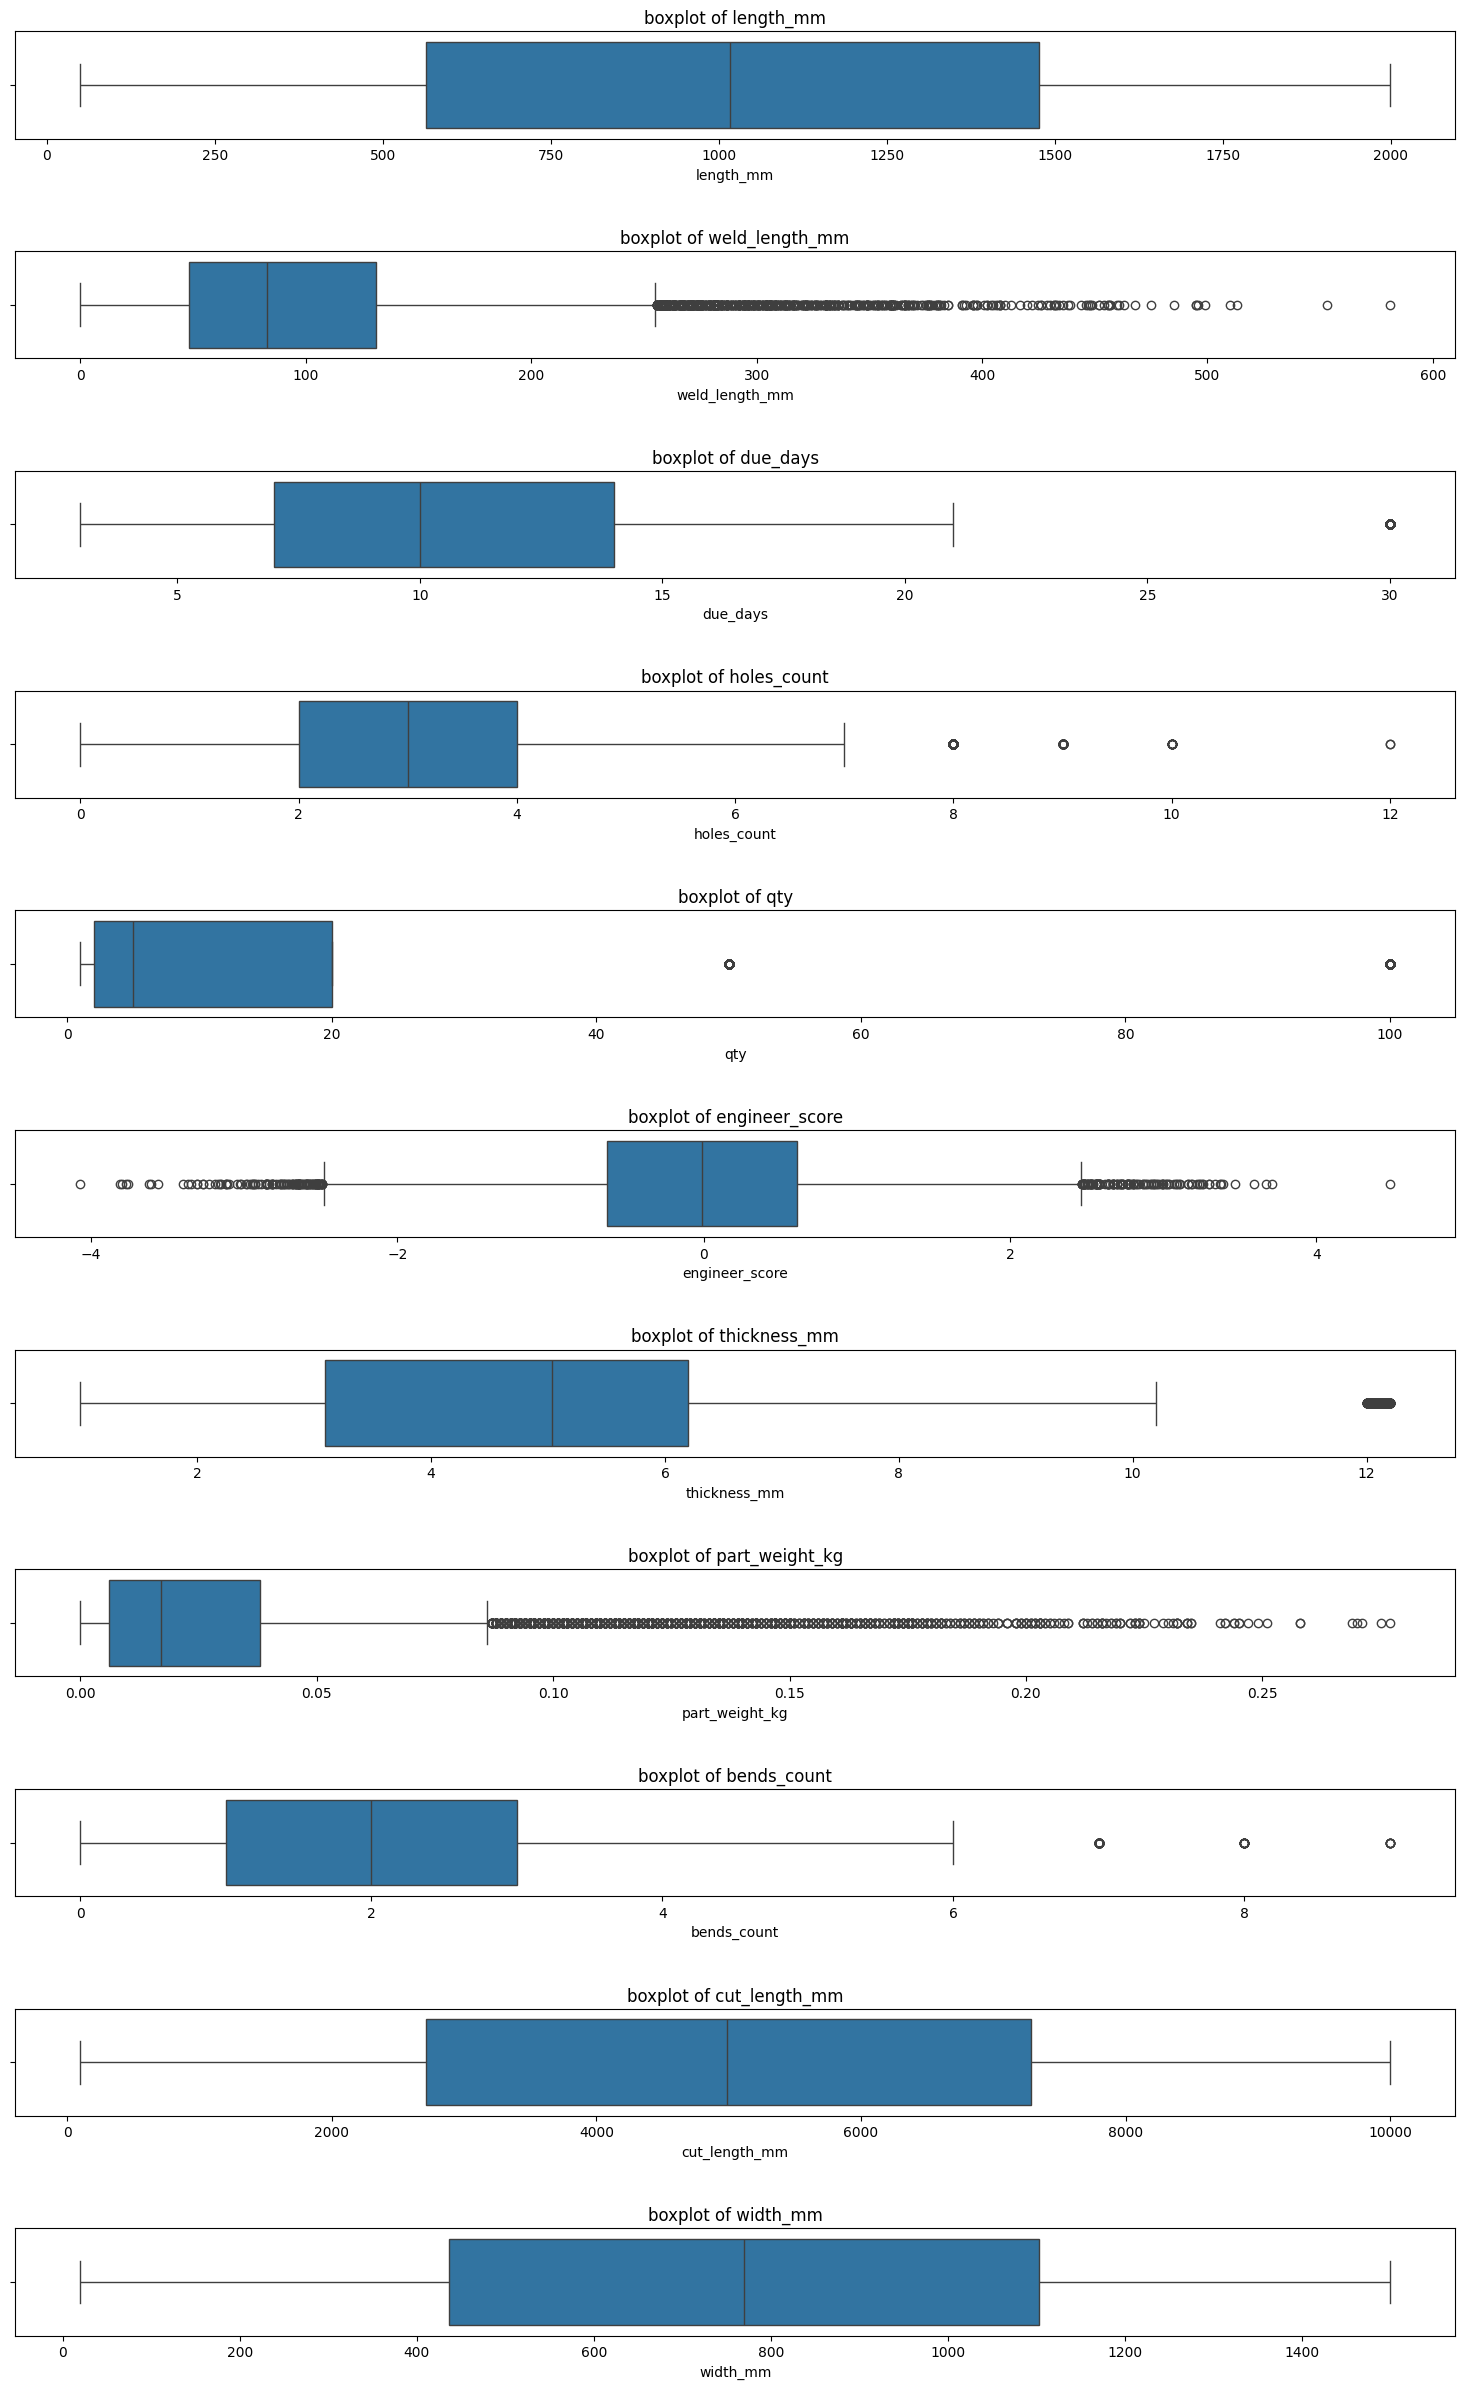

In [13]:
fig, axs = plt.subplots(len(num_features), 1)
fig.set_size_inches(16.5, 25, forward=True)
fig.tight_layout(pad=6)

for index, col in enumerate(num_features):
    sns.boxplot(x=data[col], ax=axs[index]).set_title(f"boxplot of {col}")



Не смотря на то, что некоторые признаки (due_days, qty, thickness_mm) имеют длинный правый хвост, удаление таких записей обеднит датасет. Принимаем решение оставить их для MVP решения.

## 3.3 Проверим признаками на корреляцию

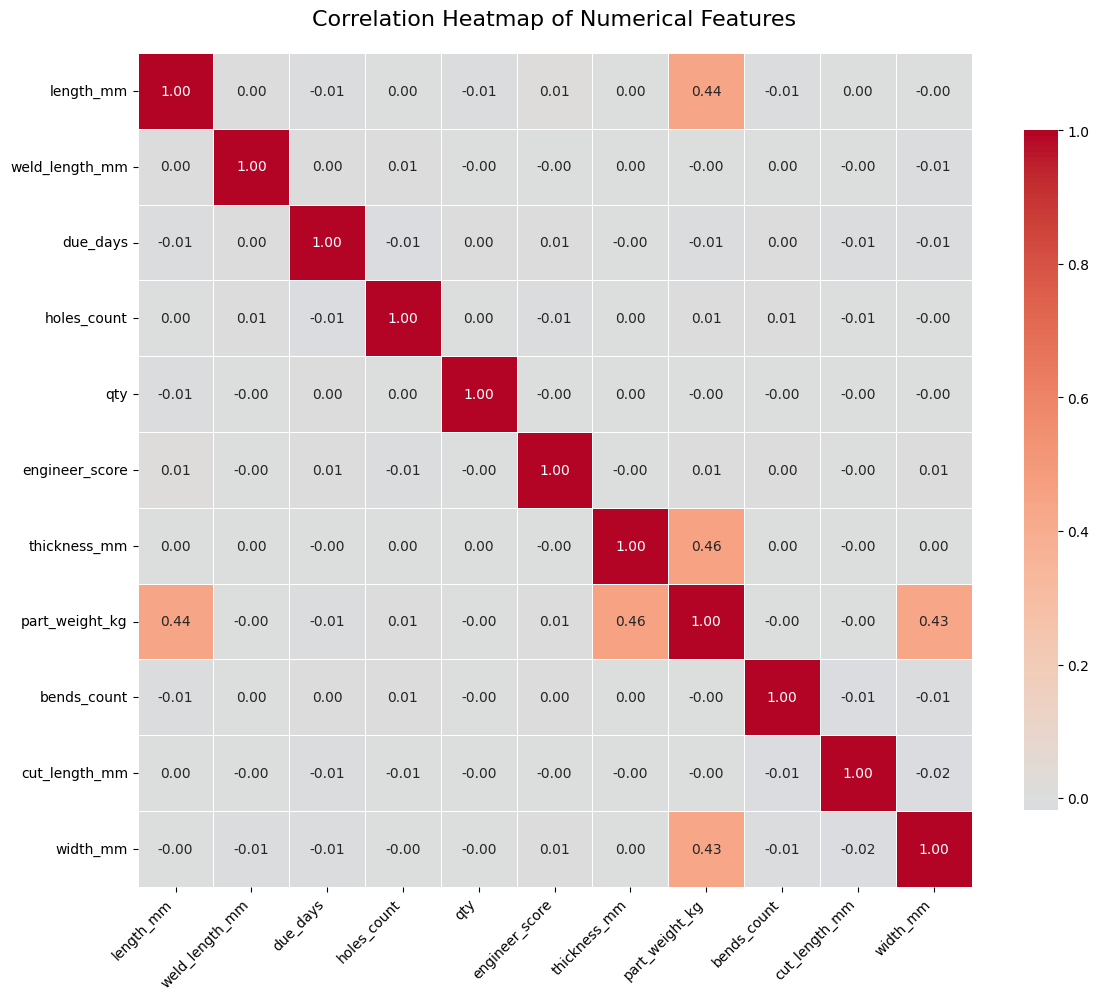

In [14]:
# Создаем матрицу корреляций
correlation_matrix = data[num_features].corr()

# Создаем heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,           # Показать значения в ячейках
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            square=True,          # Квадратные ячейки
            fmt='.2f',            # Формат чисел с двумя знаками после запятой
            linewidths=0.5,       # Ширина линий между ячейками
            cbar_kws={'shrink': 0.8})  # Настройки цветовой шкалы

plt.title('Correlation Heatmap of Numerical Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Сильных корреляций не выявленно, хотя ожидаемо весогабаритные фичи умеренокоррелируют, предоложим, что это не скажется на качестве обучения

# 4.  Анализ целевой переменной

## 4.1 Boxplot target'a

Text(0.5, 1.0, 'boxplot of target feature')

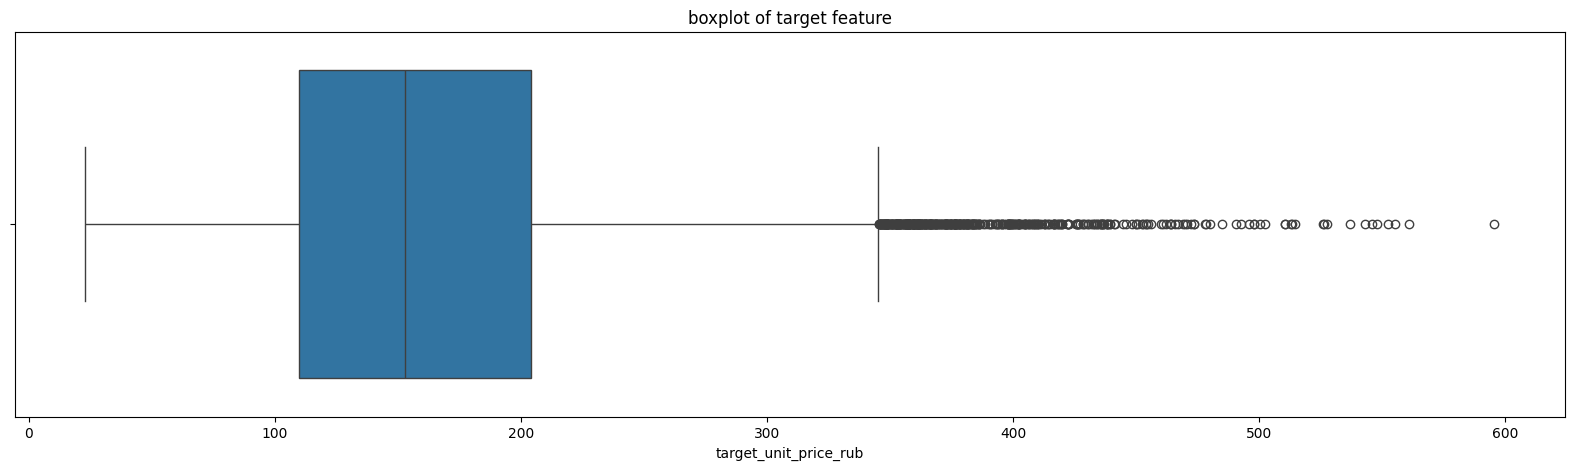

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 5, forward=True)
sns.boxplot(x=data[target], ax=ax).set_title("boxplot of target feature")

In [16]:
data[data[target]>350].shape

(395, 20)

Удалим из датасета очень дорогие КП вероятно это уникальные проекты и для таких случаев использование модели машинного обучения нецелесообразно. В качестве верхней границы выберем значение 350.

In [17]:
data = data.reset_index()

## 4.2 Посмотрим на корреляцию числовых признаков с таргетом

In [18]:
corr_matrix = data[num_features + [target]].corr()[target]
corr_matrix.head()

length_mm         0.061541
weld_length_mm    0.080983
due_days         -0.082519
holes_count      -0.002968
qty              -0.383301
Name: target_unit_price_rub, dtype: float64

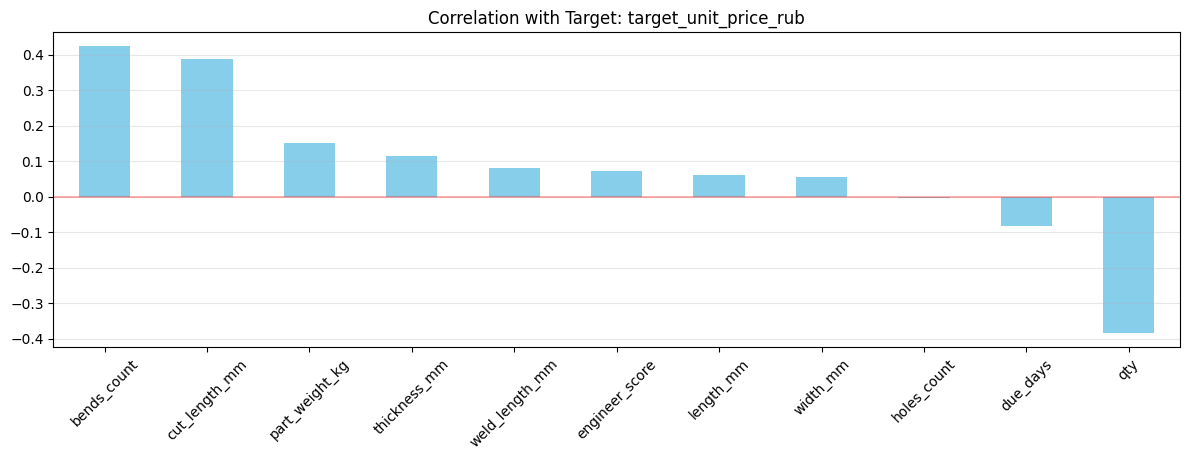

In [19]:

def plot_target_correlation(df, num_features, target, figsize=(12, 8)):
    """
    Анализ корреляции числовых признаков с таргетом
    """
    
    # Считаем корреляции с таргетом
    correlations = df[num_features + [target]].corr()[target].sort_values(ascending=False)
    
    # Убираем сам таргет из списка
    correlations = correlations[correlations.index != target]
    
    # # Визуализация
    plt.figure(figsize=figsize)
    
    # График 1: Bar plot корреляций
    plt.subplot(2, 1, 1)
    correlations.plot(kind='bar', color='skyblue')
    plt.title(f'Correlation with Target: {target}')
    plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return correlations

# Использование
correlations = plot_target_correlation(data, num_features, target)

Кажется, что количество отверстий нам не поможет на обучении. Увидим на Features impotance.

## 4.3 Features impotance

/var/folders/r1/mf9y_s494g94k8d1rwm8fwzc0000gn/T/ipykernel_1033/3464179794.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='deep')


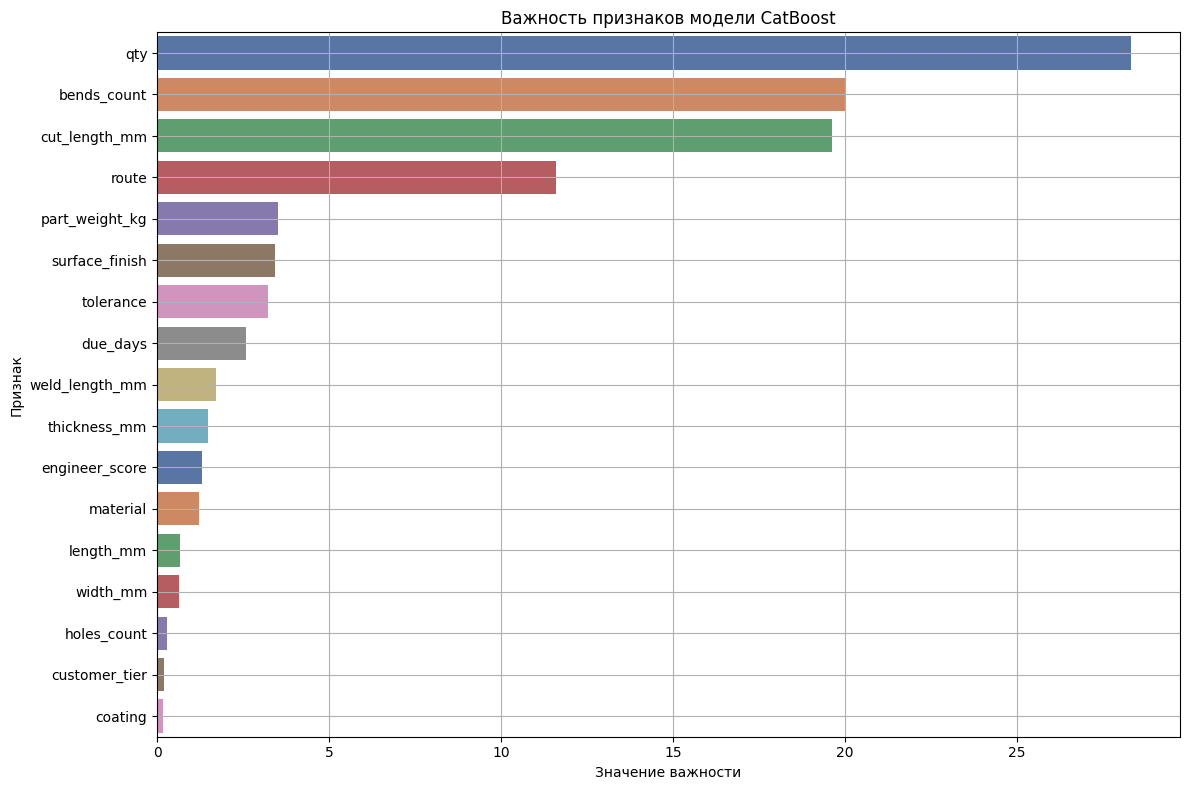

In [20]:
import os
import catboost as cb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка модели
model_path = os.path.join('models', 'price_predict.cbm')

# Загружаем модель
model = cb.CatBoostRegressor()
model.load_model(model_path)

# Получение важности признаков
feature_importance = model.get_feature_importance()
feature_names = model.feature_names_

# Создание DataFrame для удобства визуализации
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='deep')
plt.title('Важность признаков модели CatBoost')
plt.xlabel('Значение важности')
plt.ylabel('Признак')
plt.grid(True)
plt.tight_layout()

plt.show()
